# Electrode selection for stimulation: finding networks with successful synapses

Step 1: Record spontaneous activity (Spontaneous_Recording_Network_Iteration.ipynb)

Step 2: Get active electrodes (by spike count)

Step 3: Select channels for networks with active electrodes

Step 4: Create latency plots for pairs of electrodes in each network

Step 5: Analyze plots to recognize which networks have a synapse

### Import stuff

In [2]:
import numpy as np
import pickle
import pandas as pd
import os
import shutil
import glob
import matplotlib.pyplot as plt
import logging
%matplotlib ipympl

import sys
sys.path.append('home/altiki/Documents/LBB/DATA/CMOS/240607_paper_analysis/')
from Plasticity_Helper_optimized import get_latency, plot_latency
#from src.utils.electrode_selection_functions_Joel import getElectrodeListsWithSelection

### Define paths

In [2]:
CHIPID = 1851

PROCESSED_DATA_PATH = "X:/neuronies/single_neurons/3_Student_Projects/Nono/Processed_Data/2024_04_26_Spontaneous_alexschips/"
VOLTAGE_MAP_PATH = "X:/neuronies/single_neurons/3_Student_Projects/Nono/Voltage_Maps/"
ACTIVITY_MAP_PATH = "X:/neuronies/single_neurons/3_Student_Projects/Nono/Active_Electrode_Selections/"
FIGURE_PATH = "X:/neuronies/single_neurons/3_Student_Projects/Nono/Figures/Search_synapses/"
ELECTRODE_SELECTIONS_PATH = "X:/neuronies/single_neurons/3_Student_Projects/Nono/Electrode_Selections/"

file_paths = glob.glob(PROCESSED_DATA_PATH + f"*{CHIPID}*")
vmap_path = glob.glob(VOLTAGE_MAP_PATH + f"*{CHIPID}*")[0]

print(f"Found {len(file_paths)} files for chip {CHIPID}")

Found 5 files for chip 1851


### Get active electrodes

In [3]:
try:
    amap_path = glob.glob(ACTIVITY_MAP_PATH + f"*{CHIPID}*")[0]
    print(f"Found activity map for chip {CHIPID}")
except:
    amap_path = None
    print(f"No activity map found for chip {CHIPID}. Creating new activity map.")

if amap_path is None:
    spiking_electrode_list = []
    tot_spike_count = 0
    tot_electrode_count = 0

    for file_path in file_paths:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        print(f"Processing file: {file_path}")

        spikes = data['SPIKEMAT']
        tot_spike_count += spikes.shape[0]
        print(f"Number of spikes: {spikes.shape[0]}")

        electrodes = set(data['SPIKEMAT'][:,0])
        tot_electrode_count += len(electrodes)
        print(f"Number of electrodes: {len(electrodes)}")

        for electrode in spikes[:,0]:
            spiking_electrode_list.append(electrode)

    spiking_electrode_list = np.array(spiking_electrode_list, dtype='object')

    electrode_counts = np.bincount(spiking_electrode_list.astype('int64'))

    if spiking_electrode_list.shape[0] == tot_spike_count:
        print(f"All {tot_spike_count} spikes accounted for")
    else:
        print("Spikes missing")

    overlapping_electrodes =  tot_electrode_count - np.count_nonzero(electrode_counts)
    print(f"Recordings of {overlapping_electrodes} electrodes were repeated due to overlapping selections")

    if (220*120-len(electrode_counts)) != 0:
        electrode_counts = np.append(electrode_counts, np.zeros(220*120-len(electrode_counts)))

    count_matrix = electrode_counts.reshape((120,220))

    print(f"Highest spike count: {np.max(count_matrix)} at electrode {np.argmax(count_matrix)}")

    activity_matrix = count_matrix.copy()
    activity_matrix[activity_matrix < 10] = 0
    activity_matrix[activity_matrix > 1000] = 0
    np.save(os.path.join(ACTIVITY_MAP_PATH, f'ID{CHIPID}_activity_selection.npy'), activity_matrix)

    amap_path = glob.glob(ACTIVITY_MAP_PATH + f"*{CHIPID}*")[0]

Found activity map for chip 1851


### Load maps

In [4]:
voltage_map = np.load(vmap_path)
activity_map = np.load(amap_path)
#print(np.max(activity_matrix))
overlay_map = voltage_map*10 + activity_map

active_electrode_idx = np.nonzero(activity_map)
active_electrodes = []
for idx in range(len(active_electrode_idx[0])):
    x = active_electrode_idx[0][idx]
    y = active_electrode_idx[1][idx]
    electrode_number = y*220 + x
    active_electrodes.append(electrode_number)

### Check maps

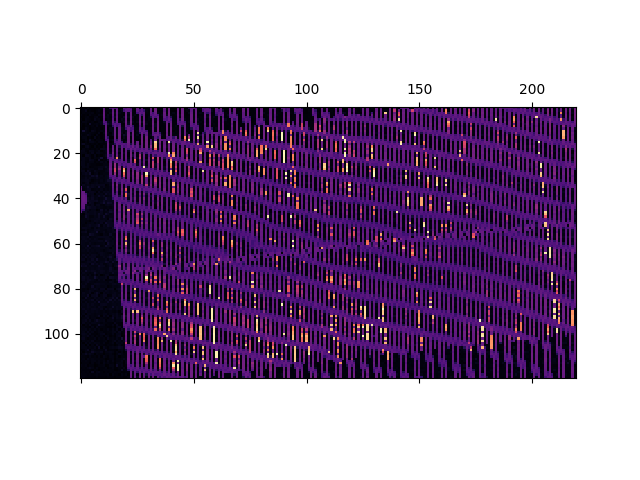

In [5]:
fig, ax = plt.subplots()
ax.matshow(overlay_map, cmap="magma")

plt.show()

### Select channels

Select always one output channel and then the respective input channel 

Add selection with left click, erase with right click, A to see selected electrodes and C to go to next channel

Keep clear_dict = False if you don't want to overwrite pickle file with previous selections

In [111]:
num_channels = 76 # Number of channels to select = 2x number of networks

In [110]:
clear_dict = False

channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")

try:
    with open(channel_file_path, 'rb') as f:
        channel_dict = pickle.load(f)
except:
    print("No channel file found. Creating a new one.")
    channel_dict = {}

if clear_dict:
        channel_dict = {}

for i in range(num_channels+1):
    channel_key = "channel" + str(i+1)
    channel = channel_dict.get(channel_key)
    if (channel is None) or (channel == []):
        print(f"Selecting electrodes for channel {i+1} in network {i//2}")
        
        recording_electrodes, stimulus_electrodes = getElectrodeListsWithSelection(
                                                overlay_map, ELECTRODE_SELECTIONS_PATH, 
                                                loadFileBool=False, n_sample=1020, 
                                                selection_threshold=100, 
                                                filename= f"ID{CHIPID}_channel_{i+1}")

        channel_dict[channel_key] = recording_electrodes
    else:
        print(f"Channel {i+1} already selected. Skipping.")
        continue
    

# Save the dictionary to a pickle file
channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")
with open(channel_file_path, 'wb') as f:
    pickle.dump(channel_dict, f)

Channel 1 already selected. Skipping.
Channel 2 already selected. Skipping.
Channel 3 already selected. Skipping.
Channel 4 already selected. Skipping.
Channel 5 already selected. Skipping.
Channel 6 already selected. Skipping.
Channel 7 already selected. Skipping.
Channel 8 already selected. Skipping.
Channel 9 already selected. Skipping.
Channel 10 already selected. Skipping.
Channel 11 already selected. Skipping.
Channel 12 already selected. Skipping.
Channel 13 already selected. Skipping.
Channel 14 already selected. Skipping.
Channel 15 already selected. Skipping.
Channel 16 already selected. Skipping.
Channel 17 already selected. Skipping.
Channel 18 already selected. Skipping.
Channel 19 already selected. Skipping.
Channel 20 already selected. Skipping.
Channel 21 already selected. Skipping.
Channel 22 already selected. Skipping.
Channel 23 already selected. Skipping.
Channel 24 already selected. Skipping.
Channel 25 already selected. Skipping.
Channel 26 already selected. Skipp

In [109]:
# for channel in range(76,70,-1):
#     print(f"Channel {channel} copied from channel {channel-1}")
#     channel_dict[f"channel{channel}"] = channel_dict[f"channel{channel-1}"]
# channel_dict['channel70'] = []
for channel_key in channel_dict.keys():
    print(f"Channel {channel_key}: {channel_dict[channel_key]}")

channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")
with open(channel_file_path, 'wb') as f:
    pickle.dump(channel_dict, f)

Channel channel1: [3749, 3969, 4189, 4409, 4629, 4849, 5069, 5289, 5509, 5729, 5949, 6169, 6389, 6609, 6829, 7049, 7269, 7489, 7709, 7929, 8149, 8369, 8589, 8809, 9029, 9249, 9469, 9689, 9909, 10129, 10349, 10569, 10789, 11009, 11229, 11449, 11669, 11889, 12109, 12329, 12330, 12549, 12550, 12769, 12770, 12989, 12990, 13210, 13430, 13650, 13870, 14090, 14310, 14530, 14750, 14970, 15190, 15410, 15630, 15850, 16070, 16290, 16510, 16730, 16950, 17170, 17390, 17610, 17830, 18050, 18270, 18490, 18710, 18930, 19150, 19370, 19590, 19810, 20030, 20250, 20470, 20690]
Channel channel2: [1110, 1330, 1550, 1770, 1990, 2210, 2430, 2650, 2870, 3090, 3310, 3530, 3750, 3970, 4190, 4191, 4410, 4411, 4630, 4631, 4850, 4851, 5071, 5291, 5511, 5731, 5951, 6171, 6391, 6611, 6831, 7051, 7271, 7491, 7711, 7931, 8151, 8371, 8591, 8811, 9031, 9251, 9471, 9691, 9911, 10131, 10351, 10571, 10791, 11011, 11231, 11451, 11671, 11891, 12111, 12331, 12551, 12771]
Channel channel3: [8825, 9045, 9265, 9485, 9705, 9925, 1

In [15]:
#Modify a single channel
network_modify = 7

channel_modify = "input"

channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")

try:
    with open(channel_file_path, 'rb') as f:
        channel_dict = pickle.load(f)
except:
    logging.info("No channel file found. Creating a new one.")

if channel_modify == "output":
    i = network_modify*2
else:
    i = network_modify*2+1

channel_key = "channel" + str(i+1)
channel = channel_dict.get(channel_key)
if (channel is None) or (channel == []):
    print(f"Selecting electrodes for channel {i+1} in network {i//2}")
    
    recording_electrodes, stimulus_electrodes = getElectrodeListsWithSelection(
                                            overlay_map, ELECTRODE_SELECTIONS_PATH, 
                                            loadFileBool=False, n_sample=1020, 
                                            selection_threshold=300, 
                                            filename= f"ID{CHIPID}_channel_{i+1}")

    channel_dict[channel_key] = recording_electrodes
else:
    overwrite = input(f"Channel {i+1} in network {i//2} ({channel_modify}) already selected. Are you sure you want to overwrite? (y/n)")
    if overwrite.lower() == 'y':
        # Overwrite the channel
        print(f"Selecting new electrodes for channel {i+1} in network {i//2}")
        recording_electrodes, stimulus_electrodes = getElectrodeListsWithSelection(
                                                overlay_map, ELECTRODE_SELECTIONS_PATH, 
                                                loadFileBool=False, n_sample=1020, 
                                                selection_threshold=300, 
                                                filename= f"ID{CHIPID}_channel_{i+1}")

        channel_dict[channel_key] = recording_electrodes
    else:
        print("Channel not overwritten.")
    
    

# Save the dictionary to a pickle file
channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")
with open(channel_file_path, 'wb') as f:
    pickle.dump(channel_dict, f)

Selecting new electrodes for channel 16 in network 7
electrodes selected:  44 



### Check selected networks

In [86]:
with open(channel_file_path, 'rb') as f:
    channel_dict = pickle.load(f)

Button(description="Press 'ArrowRight' or 'ArrowLeft' to switch figures", style=ButtonStyle())

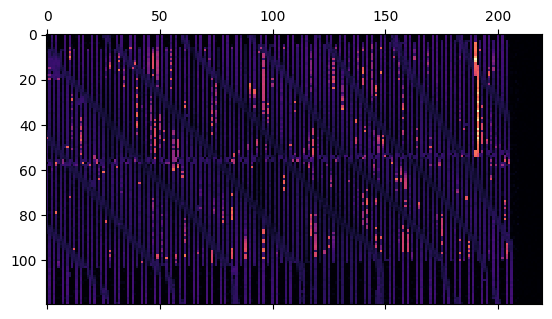

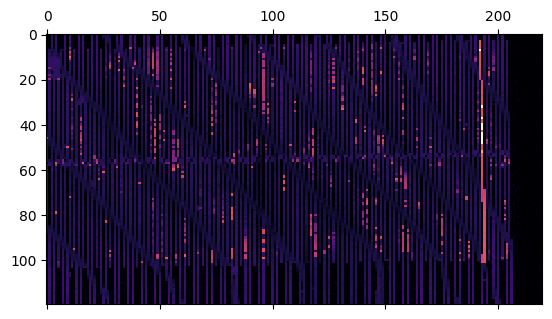

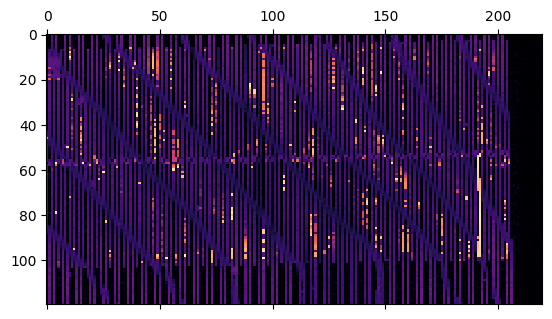

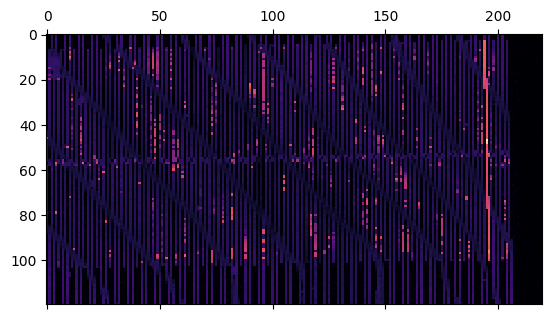

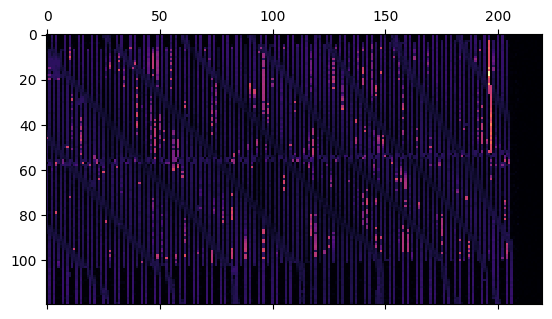

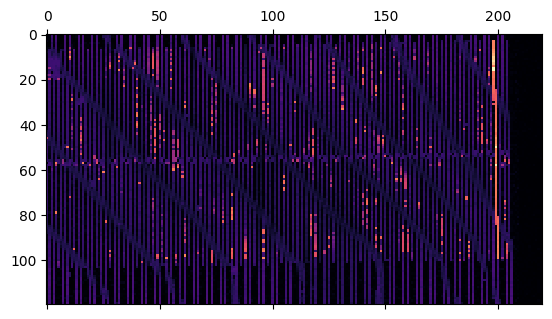

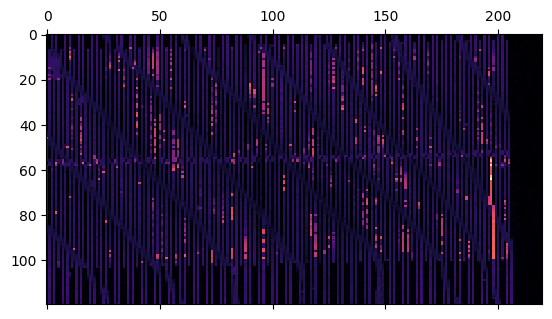

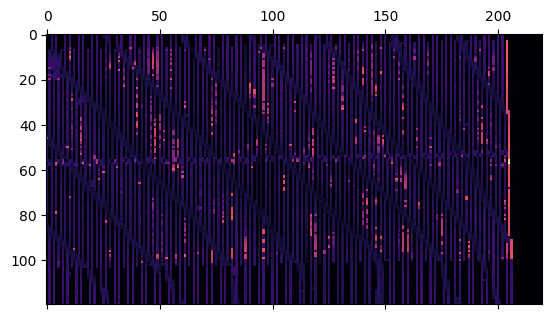

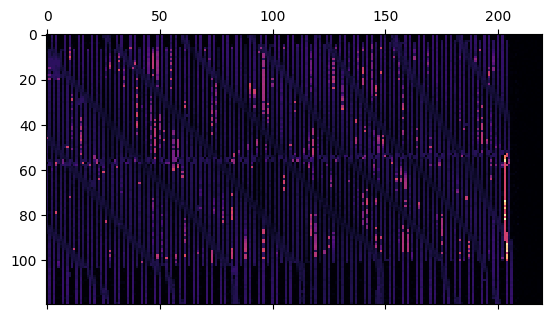

In [112]:
%matplotlib inline

import matplotlib.pyplot as plt
from ipyevents import Event
from IPython.display import display, clear_output
from ipywidgets import Button


figures = []
current_figure_index = 0

for channel in range(67,num_channels):
    network_selection_map = overlay_map.copy()
    channel_key = "channel" + str(channel+1)
    
    for electrode_number in channel_dict[channel_key]:
        electrode_position = (electrode_number // 220, electrode_number % 220)
        network_selection_map[electrode_position] += 1000

    fig, ax = plt.subplots()
    ax.matshow(network_selection_map, cmap="magma")
    figures.append(fig)


# Function to switch between figures
def switch_figure(event):
    global current_figure_index

    # Clear the current output
    clear_output(wait=True)
    
    if event['key'] == 'ArrowRight':
        # Go to the next figure
        current_figure_index = (current_figure_index + 1) % len(figures)
    elif event['key'] == 'ArrowLeft':
        # Go to the previous figure
        current_figure_index = (current_figure_index - 1) % len(figures)

    # Display the current figure
    plt.show(figures[current_figure_index])

# Create a button to capture the keyboard events
button = Button(description="Press 'ArrowRight' or 'ArrowLeft' to switch figures")

# Create an Event and connect the function to the keydown event
event = Event(source=button, watched_events=['keydown'])
event.on_dom_event(switch_figure)

# Display the first figure
display(button)
plt.show(figures[current_figure_index])

76


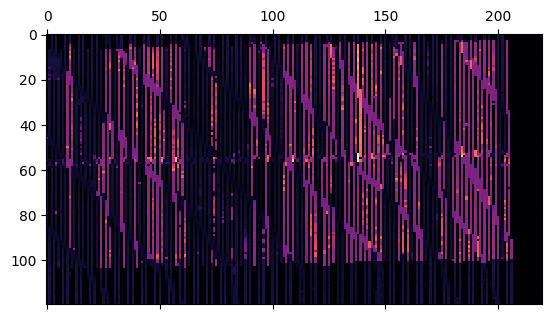

In [113]:
network_selection_map = overlay_map.copy()

channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")
with open(channel_file_path, 'rb') as f:
        channel_dict = pickle.load(f)
print(len(channel_dict))

for channel in range(0,len(channel_dict)):
    channel_key = "channel" + str(channel+1)
#     if channel <= 66:
#          continue
    for i, electrode_number in enumerate(channel_dict[channel_key]):
        electrode_position = (electrode_number // 220, electrode_number % 220)
        network_selection_map[electrode_position] += 1000


fig, ax = plt.subplots()
ax.matshow(network_selection_map, cmap="magma")

plt.show()

### Plot single latency plot

In [ ]:
for file_path in file_paths: 
    print(f'Processing file: {file_path}')
    with open(file_path, 'rb') as spikes_file:
        data = pickle.load(spikes_file)
    spikes	= np.vstack((spikes, data['SPIKEMAT'])) if spikes.size else data['SPIKEMAT']

input_electrode_position = (91,85) 
input_electrode_number = input_electrode_position[0]*220 + input_electrode_position[1]

output_electrode_position = (94,87)
output_electrode_number = output_electrode_position[0]*220 + output_electrode_position[1]

print(input_electrode_number, output_electrode_number)

latency = get_latency(spikes, input_electrode_number, output_electrode_number, 10, 4000)
print(latency)
plot_latency(latency, input_electrode_number, output_electrode_number, CHIPID, 0, FIGURE_PATH, 'exp_time')

### Load spikes

In [114]:
spikes = np.zeros((0,3))

for file_path in file_paths:
    with open(file_path, 'rb') as spikes_file:
        data = pickle.load(spikes_file)

    spikes = np.vstack([spikes, data['SPIKEMAT']])

### Plot latency plots for all pairwise input and output electrodes in the networks selected

In [ ]:
plot_type = 'per network' # 'all', 'per region', 'per network'

if plot_type == 'all':
    plotting_electrodes = []
    for electrode in active_electrodes:
        if spikes[spikes[:,0]==electrode].shape[0] >20:
            plotting_electrodes.append(electrode)
    print('Checkpoint')
    for output_electrode in plotting_electrodes:
        for input_electrode in plotting_electrodes:
            if input_electrode != output_electrode:
                print(f"Plotting latency for input {input_electrode} and output {output_electrode}")
                latency = get_latency(spikes, input_electrode, output_electrode, 20, 10000)
                try:
                    if latency == -1:
                        print(f"Error: not enough spikes for input {input_electrode} or output {output_electrode}")
                    elif latency == -2:
                        print(f"Error: too many spikes for input {input_electrode} or output {output_electrode}, electrode might be broken")
                except:
                    plot_latency(latency, input_electrode, output_electrode, CHIPID, 0, FIGURE_PATH)
                    print(f"Latency plot for input {input_electrode} and output {output_electrode} saved")

elif plot_type == 'per region':
    
    channel_dict = {}
    channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")

    with open(channel_file_path, 'rb') as channels_file:
        channel_dict = pickle.load(channels_file)

    for region in range(3, num_channels):
        plotting_electrodes = []
        region_electrodes = channel_dict["channel" + str(region+1)]
        for electrode in region_electrodes:
            if spikes[spikes[:,0]==electrode].shape[0] >20:
                plotting_electrodes.append(electrode)
        for output_electrode in plotting_electrodes:
            for input_electrode in plotting_electrodes:
                if input_electrode != output_electrode:
                    # list_of_files = os.listdir(FIGURE_PATH)
                    # list_of_files = [file for file in list_of_files if f'network{region}' in file]
                    # if f'latency_ID{CHIPID}_network{region}_in_{input_electrode}_out_{output_electrode}.png' in list_of_files:
                    #     print(f"Latency plot for input {input_electrode} and output {output_electrode} already exists")
                    # else:
                    print(f"Plotting latency for input {input_electrode} and output {output_electrode} in region {region}")
                    latency = get_latency(spikes, input_electrode, output_electrode, 20, 10000)
                    try:
                        if latency == -1:
                            print(f"Error: not enough spikes for input {input_electrode} or output {output_electrode}")
                        elif latency == -2:
                            print(f"Error: too many spikes for input {input_electrode} or output {output_electrode}, electrode might be broken")
                    except:
                        plot_latency(latency, input_electrode, output_electrode, CHIPID, region, FIGURE_PATH, 'exp_time')
                        print(f"Latency plot for input {input_electrode} and output {output_electrode} saved")

elif plot_type == 'per network':
    channel_dict = {}
    channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")

    with open(channel_file_path, 'rb') as channels_file:
        channel_dict = pickle.load(channels_file)

    for network in range(num_channels//2):
        output_channel_key = "channel" + str(2*network+1)
        input_channel_key = "channel" + str(2*network+2)
        output_electrodes = channel_dict[output_channel_key]
        input_electrodes = channel_dict[input_channel_key]
        for output_electrode in output_electrodes:
            for input_electrode in input_electrodes:
                if input_electrode != output_electrode:
                    print(f"Plotting latency for input {input_electrode} and output {output_electrode}")
                    latency = get_latency(spikes, input_electrode, output_electrode, 10, 5000)
                    if isinstance(latency, int):
                        if latency == -1:
                            print(f"Error: not enough spikes for input {input_electrode} or output {output_electrode}")
                        elif latency == -2:
                            print(f"Error: too many spikes for input {input_electrode} or output {output_electrode}, electrode might be broken")
                    else:
                        plot_latency(latency, input_electrode, output_electrode, CHIPID, network, FIGURE_PATH, y_axis='exp_time')
                        print(f"Latency plot for input {input_electrode} and output {output_electrode} saved")
                

### Plot latency plots for all input electrodes of each network

In [115]:
spike_count_threshold = 10
broken_electrode_threshold = 3000
binsize = 1 #ms
bin_overlap = 0.2 #ms
nbins = round(20//(binsize-bin_overlap))
print(nbins)

# Get the channel dictionary
channel_dict = {}
channel_file_path = os.path.join(ELECTRODE_SELECTIONS_PATH, f"ID{CHIPID}_channels.pkl")
with open(channel_file_path, 'rb') as channels_file:
    channel_dict = pickle.load(channels_file)

# Get the color map
cmap = plt.get_cmap('magma')
#colors = [cmap.colors[i] for i in np.linspace(0, cmap.N-1, c).astype(int)]

cmap2 = plt.get_cmap('spring')
input_color = cmap2(9)

# plt.figure()
# ax = plt.gca()
# ax.scatter(0,0,color=input_color)


24


Skipping input electrode 1110
Plotting latencies for input 1330 in network 0
Found 82 output electrodes for input electrode 1330
Figures saved for input electrode 1330, 83 output electrodes plotted
Plotting latencies for input 1550 in network 0
Found 82 output electrodes for input electrode 1550
Figures saved for input electrode 1550, 83 output electrodes plotted
Plotting latencies for input 1770 in network 0
Found 82 output electrodes for input electrode 1770
Figures saved for input electrode 1770, 83 output electrodes plotted
Plotting latencies for input 1990 in network 0
Found 82 output electrodes for input electrode 1990
Figures saved for input electrode 1990, 83 output electrodes plotted
Plotting latencies for input 2210 in network 0
Found 82 output electrodes for input electrode 2210
Figures saved for input electrode 2210, 83 output electrodes plotted
Plotting latencies for input 2430 in network 0
Found 82 output electrodes for input electrode 2430
Figures saved for input electro

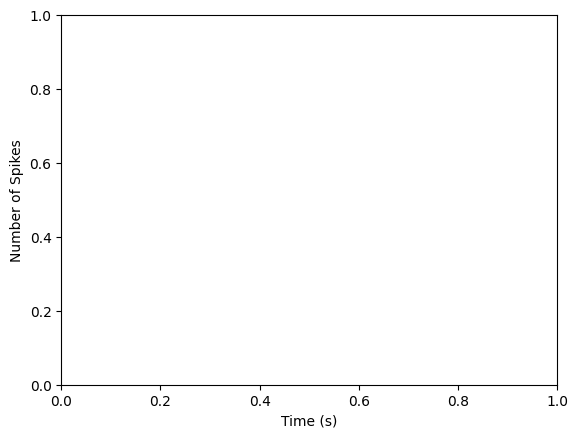

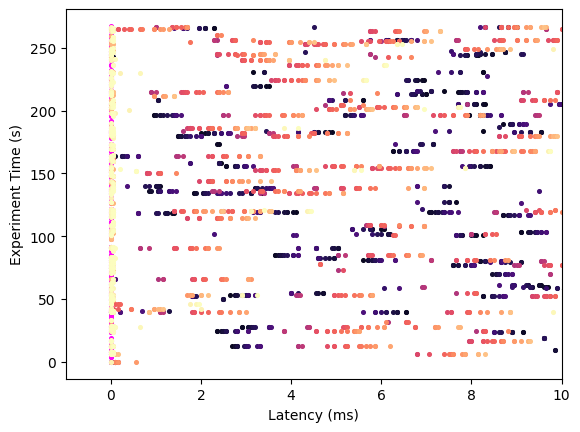

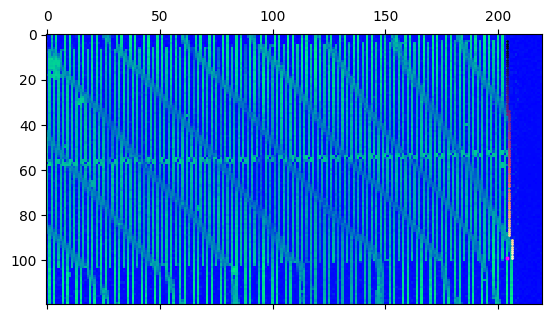

In [116]:
for network in range(num_channels//2):
    # Get the output and input electrodes for the network
    output_channel_key = "channel" + str(2*network+1)
    input_channel_key = "channel" + str(2*network+2)
    output_electrodes = channel_dict[output_channel_key]
    input_electrodes = channel_dict[input_channel_key]

    # Create a new folder for the figures of the network
    new_folder_name = f'ID{CHIPID}_network{network}/'
    if not os.path.exists(os.path.join(FIGURE_PATH,new_folder_name)):
        os.mkdir(os.path.join(FIGURE_PATH,new_folder_name))

    for input_electrode in input_electrodes:
        input_spikes = spikes[spikes[:,0]==input_electrode]
        if input_spikes.shape[0] < spike_count_threshold or input_spikes.shape[0] > broken_electrode_threshold:
            print(f'Skipping input electrode {input_electrode}')
            continue
        print(f'Plotting latencies for input {input_electrode} in network {network}')
        plt.close('all')

        # Create new figure for latency
        fig1, ax1 = plt.subplots()
        ax1.set_ylabel("Experiment Time (s)")
        ax1.set_xlim((-1,10)) 
        ax1.set_xlabel("Latency (ms)")   

        # Create new figure for voltage map
        fig2, ax2 = plt.subplots()
        ax2 = plt.gca()
        ax2.matshow(voltage_map, cmap="winter")

        # Create new figure for histogram
        fig3, ax3 = plt.subplots()
        ax3.set_ylabel("Number of Spikes")
        ax3.set_xlabel("Time (s)")

        # Count good output electrodes
        c = 0
        output_electrodes_filtered = []
        for output_electrode in output_electrodes:
            if input_electrode != output_electrode:
                input_spikes = spikes[spikes[:,0]==input_electrode]
                if input_spikes.shape[0] < spike_count_threshold or input_spikes.shape[0] > broken_electrode_threshold:
                    print(f'Skipping input electrode {input_electrode}')
                    continue
                else:
                    output_electrodes_filtered.append(output_electrode)
                    c += 1
        print(f'Found {c} output electrodes for input electrode {input_electrode}')

        # Define colors
        colors = [cmap.colors[i] for i in np.linspace(0, cmap.N-1, c).astype(int)]

        # Plot
        c = 0
        for output_electrode in output_electrodes_filtered:
            if input_electrode != output_electrode:
                
                # Get the latency
                latency = get_latency(spikes, input_electrode, output_electrode)

                # Separate input and output spikes
                input_before = latency[latency['category']=='input']
                output_before = latency[latency['category']=='output']

                # Plot the input spikes on the first iteration
                if c==0:
                    ax1.scatter(input_before['latency'], input_before['spike time']/1000, s=7, label='input', color=input_color)
                    input_electrode_position = (input_electrode // 220, input_electrode % 220)
                    ax2.scatter(input_electrode_position[1], input_electrode_position[0], color=input_color, s=3, marker='s')
                    c += 1

                # Plot the output spikes
                ax1.scatter(output_before['latency'], output_before['spike time']/1000, s=7, label='output', color=colors[c-1])
                output_electrode_position = (output_electrode // 220, output_electrode % 220)
                ax2.scatter(output_electrode_position[1], output_electrode_position[0], color=colors[c-1], s=1)
                
                # Histogram of output spike counts
                # output = latency[latency['category']=='output']
                # output_band = output[output['latency']<3]
                # output_band = output_band[output_band['latency']>1]

                # output_spike_counts = np.array([[]], dtype=[('bin', 'i4'), ('value', 'f4')])

                # for bin in range(nbins):
                #     bin_start = bin*(binsize-bin_overlap)
                #     bin_end = bin_start + binsize

                #     # filter for bin
                #     output_bin = output_band[(output_band['latency'] >= bin_start) & (output_band['latency'] < bin_end)]

                #     # count spikes
                #     output_count = output_bin.shape[0]
                #     output_spike_counts = np.append(output_spike_counts, np.array([(bin, output_count)], dtype=output_spike_counts.dtype))

                # ax3.plot(output_spike_counts['bin']*(binsize-bin_overlap), output_spike_counts['value'], label=f'Output {output_electrode}', color=colors[c-1]) 
                c += 1

        input_electrode_position = (input_electrode // 220, input_electrode % 220)
        ax2.scatter(input_electrode_position[1], input_electrode_position[0], color=input_color, s=3, marker='s')

        # Save figures
        figure_name = f'latency_ID{CHIPID}_network{network}_in_{input_electrode}'
        vmap_name = f'latency_ID{CHIPID}_network{network}_in_{input_electrode}_VoltageMap'
        histogram_name = f'latency_ID{CHIPID}_network{network}_in_{input_electrode}_Histogram'
        
        plt.figure(1)
        plt.savefig(os.path.join(FIGURE_PATH,new_folder_name, figure_name))
        plt.figure(2)
        plt.savefig(os.path.join(FIGURE_PATH,new_folder_name, vmap_name))
        #plt.figure(3)
        #plt.savefig(os.path.join(FIGURE_PATH,new_folder_name, histogram_name))

        print(f'Figures saved for input electrode {input_electrode}, {c} output electrodes plotted')

                

In [ ]:

output = latency[latency['category']=='output']
output_band = output[output['latency']<3]
output_band = output_band[output_band['latency']>1]

output_spike_counts = np.array([[]], dtype=[('bin', 'i4'), ('value', 'f4')])

for bin in range(nbins):
    bin_start = bin*(binsize-bin_overlap)
    bin_end = bin_start + binsize

    # filter for bin
    output_bin = output_band[(output_band['spike time'] >= bin_start*1000) & (output_band['spike time'] < bin_end*1000)]

    # count spikes
    output_count = output_bin.shape[0]
    


### Check synapses

Look at the plots and fill in the electrode pairs that yielded good plots into electrode_pairs

The brightest electrodes are the outputs, the second brightest are the inputs

In [ ]:
chosen_electrode_path = "Chosen_Electrodes/"
figure_paths = glob.glob(os.path.join(FIGURE_PATH, chosen_electrode_path) + f"*{CHIPID}*" + "*.png*")
figure_names = [os.path.basename(path) for path in figure_paths]
                          
electrode_pairs = np.load(os.path.join(PROCESSED_DATA_PATH, 'synapse_selection.npy'))



for name in figure_names:
    name = name[:-4]

    if not os.path.exists(os.path.join(FIGURE_PATH,chosen_electrode_path,name)):
        os.mkdir(os.path.join(FIGURE_PATH,chosen_electrode_path,name))

    input_electrode_number = int(name.split("_")[4])
    output_electrode_number = int(name.split("_")[6])
    CHIPID = int(name.split("_")[1][2:])
    network_number = int(name.split("_")[2][7:])
    electrode_pairs = np.append(electrode_pairs, np.array([(CHIPID,0,input_electrode_number,output_electrode_number)],dtype=[('Chip ID', 'i4'), ('Network ID', 'i4'), ('Input electrode', 'f4'), ('Output electrode', 'f4')]))
    
    vmap_path = glob.glob(VOLTAGE_MAP_PATH + f"*{CHIPID}*")[0]
    voltage_map = np.load(vmap_path)
    synapse_selection_map = voltage_map.copy()

    input_electrode_position = (input_electrode_number // 220, input_electrode_number % 220)
    output_electrode_position = (output_electrode_number // 220, output_electrode_number % 220)
    synapse_selection_map[input_electrode_position] = 100
    synapse_selection_map[output_electrode_position] = 120

    fig, ax = plt.subplots()
    ax.matshow(synapse_selection_map, cmap="magma")

    figure_name = f'latency_ID{CHIPID}_network{0}_in_{input_electrode_number}_out_{output_electrode_number}_Voltage_Map'

    print(os.path.join(FIGURE_PATH,chosen_electrode_path, figure_name))

    plt.savefig(os.path.join(FIGURE_PATH,chosen_electrode_path, figure_name))

# for file_path in figure_paths:

#     file_name = os.path.basename(file_path)

#     folder_name = file_name[:-4]

#     # Check if a file with the same name already exists at the destination
#     if not os.path.exists(os.path.join(FIGURE_PATH,chosen_electrode_path,folder_name,file_name)):
#         # If not, move the file
#         shutil.move(file_path, os.path.join(FIGURE_PATH,chosen_electrode_path,folder_name))
#     else:
#         print(f"A file with the name {file_name} already exists at the destination.")

np.save(os.path.join(PROCESSED_DATA_PATH, 'synapse_selection.npy'), electrode_pairs)


### Define electrode pairs for plasticity analysis

In [ ]:


CHIPID = 1767

vmap_path = glob.glob(VOLTAGE_MAP_PATH + f"*{CHIPID}*")[0]
voltage_map = np.load(vmap_path)
synapse_selection_map = voltage_map.copy()

electrode_pairs = np.load(os.path.join(PROCESSED_DATA_PATH, 'synapse_selection.npy'))
electrode_pairs_filtered = electrode_pairs[electrode_pairs['Chip ID'] == CHIPID]

for electrode_number in electrode_pairs_filtered['Input electrode']:
    print(electrode_number)
    electrode_position = (electrode_number // 220, electrode_number % 220)
    electrode_position = tuple(map(int, electrode_position))
    synapse_selection_map[electrode_position] = 100

for electrode_number in electrode_pairs_filtered['Output electrode']:
    print(electrode_number)
    electrode_position = (electrode_number // 220, electrode_number % 220)
    electrode_position = tuple(map(int, electrode_position))
    synapse_selection_map[electrode_position] = 100


fig, ax = plt.subplots()
ax.matshow(synapse_selection_map, cmap="magma")

figure_name = f'ID{CHIPID}_network{network_number}_all_electrodes_with_synapses'

print(os.path.join(FIGURE_PATH, figure_name))

plt.savefig(os.path.join(FIGURE_PATH, figure_name))


In [ ]:
chosen_electrode_path = "Chosen_Electrodes/weird_yellow_ones/"

for folder in os.listdir(os.path.join(FIGURE_PATH,chosen_electrode_path)):
    if not folder.endswith(".png"):
        for file in os.listdir(os.path.join(FIGURE_PATH,chosen_electrode_path,folder)):
            if file == "Voltage_Map.png":
                file_path = os.path.join(FIGURE_PATH,chosen_electrode_path,folder,file)
                new_file_name = folder + "_Voltage_Map.png"
                new_file_path = os.path.join(FIGURE_PATH,chosen_electrode_path,folder,new_file_name)
                if not os.path.exists(new_file_path):
                    os.rename(file_path, new_file_path)
                else:
                    print(f"A file with the name {new_file_name} already exists at the destination.")
        for file in os.listdir(os.path.join(FIGURE_PATH,chosen_electrode_path,folder)):
            file_path = os.path.join(FIGURE_PATH,chosen_electrode_path,folder,file)
            if not os.path.exists(os.path.join(FIGURE_PATH,chosen_electrode_path,file)):
                shutil.move(file_path, os.path.join(FIGURE_PATH,chosen_electrode_path))
            else:
                print(f"A file with the name {file} already exists at the destination.")



# # Specify the current file path and the new file name
# file_path = "path_to_your_file"
# new_file_name = "new_file_name"

# # Get the directory of the file
# dir_name = os.path.dirname(file_path)

# # Create the new file path
# new_file_path = os.path.join(dir_name, new_file_name)

# # Rename the file
# os.rename(file_path, new_file_path)

In [ ]:
synapse_selection_map = voltage_map.copy()

electrode_pairs_filtered = electrode_pairs[electrode_pairs['Chip ID'] == CHIPID]

p4868 = (4868 // 220, 4868 % 220)
p9045 = (9045 // 220, 9045 % 220)
p9484 = (9484 // 220, 9484 % 220)
p7065 = (7065 // 220, 7065 % 220)
p8165 = (8165 // 220, 8165 % 220)
p7287 = (7287 // 220, 7287 % 220)
p7727 = (7727 // 220, 7727 % 220)
p6847 = (6847 // 220, 6847 % 220)

synapse_selection_map[p4868] = 140
synapse_selection_map[p9045] = 100
synapse_selection_map[p9484] = 100
synapse_selection_map[p7065] = 100
synapse_selection_map[p8165] = 100
synapse_selection_map[p7287] = 120
synapse_selection_map[p7727] = 120
synapse_selection_map[p6847] = 120

fig, ax = plt.subplots()
ax.matshow(synapse_selection_map, cmap="magma")


In [123]:
recording_electrodes = [808, 835, 842, 843, 844, 864, 1026, 1028, 1030, 1055, 1063, 1064, 1065, 1084, 1207, 1213, 1215, 1217, 1246, 1248, 1250, 1275, 1283, 1284, 1285, 1304, 1369, 1371, 1375, 1377, 1427, 1429, 1433, 1435, 1437, 1466, 1468, 1470, 1495, 1503, 1504, 1505, 1524, 1547, 1548, 1550, 1589, 1591, 1595, 1597, 1647, 1649, 1653, 1655, 1657, 1686, 1688, 1690, 1715, 1723, 1724, 1725, 1744, 1768, 1770, 1809, 1811, 1815, 1817, 1867, 1869, 1873, 1875, 1877, 1906, 1908, 1910, 1935, 1943, 1944, 1945, 1964, 1988, 1990, 2029, 2031, 2035, 2037, 2087, 2089, 2093, 2095, 2097, 2126, 2128, 2130, 2155, 2163, 2165, 2184, 2208, 2210, 2249, 2251, 2255, 2257, 2307, 2309, 2313, 2315, 2317, 2346, 2348, 2350, 2375, 2383, 2385, 2404, 2428, 2430, 2469, 2471, 2475, 2477, 2527, 2529, 2533, 2535, 2537, 2566, 2568, 2570, 2595, 2603, 2605, 2624, 2648, 2650, 2689, 2691, 2695, 2697, 2747, 2749, 2753, 2755, 2757, 2786, 2788, 2790, 2815, 2823, 2825, 2844, 2868, 2870, 2909, 2911, 2915, 2917, 2967, 2969, 2973, 2975, 2977, 3006, 3008, 3010, 3035, 3043, 3045, 3064, 3088, 3090, 3129, 3131, 3135, 3137, 3187, 3189, 3193, 3195, 3197, 3226, 3228, 3230, 3255, 3263, 3265, 3284, 3308, 3310, 3349, 3351, 3355, 3357, 3407, 3409, 3413, 3415, 3417, 3446, 3448, 3450, 3475, 3483, 3485, 3504, 3528, 3530, 3569, 3571, 3575, 3577, 3627, 3629, 3633, 3635, 3637, 3666, 3668, 3670, 3695, 3703, 3705, 3724, 3748, 3749, 3750, 3789, 3791, 3795, 3797, 3847, 3849, 3853, 3855, 3857, 3886, 3888, 3890, 3915, 3923, 3925, 3944, 3968, 3969, 3970, 4009, 4011, 4015, 4017, 4067, 4069, 4073, 4075, 4077, 4106, 4108, 4110, 4135, 4143, 4145, 4164, 4188, 4189, 4190, 4191, 4229, 4231, 4235, 4237, 4287, 4288, 4289, 4293, 4295, 4297, 4326, 4328, 4330, 4355, 4363, 4365, 4384, 4409, 4410, 4411, 4449, 4451, 4455, 4457, 4507, 4508, 4509, 4513, 4515, 4517, 4546, 4548, 4550, 4575, 4583, 4585, 4604, 4629, 4630, 4631, 4669, 4671, 4675, 4677, 4727, 4728, 4729, 4733, 4735, 4737, 4766, 4768, 4770, 4795, 4803, 4805, 4824, 4849, 4850, 4851, 4889, 4891, 4895, 4897, 4948, 4949, 4953, 4955, 4957, 4986, 4988, 4990, 5015, 5023, 5025, 5044, 5069, 5071, 5109, 5111, 5115, 5117, 5168, 5169, 5173, 5175, 5177, 5206, 5208, 5210, 5235, 5243, 5245, 5264, 5289, 5291, 5329, 5331, 5335, 5337, 5388, 5389, 5393, 5395, 5397, 5426, 5428, 5430, 5455, 5463, 5465, 5484, 5509, 5511, 5549, 5550, 5551, 5555, 5557, 5608, 5613, 5615, 5617, 5646, 5648, 5650, 5675, 5683, 5685, 5704, 5729, 5731, 5769, 5770, 5771, 5775, 5777, 5828, 5833, 5835, 5837, 5866, 5868, 5870, 5895, 5903, 5905, 5924, 5949, 5951, 5989, 5990, 5991, 5992, 5995, 5997, 6048, 6053, 6054, 6055, 6057, 6086, 6088, 6090, 6115, 6123, 6125, 6144, 6169, 6171, 6210, 6211, 6212, 6215, 6217, 6268, 6273, 6274, 6275, 6277, 6306, 6308, 6310, 6335, 6343, 6345, 6364, 6389, 6391, 6430, 6431, 6432, 6435, 6437, 6488, 6493, 6494, 6495, 6497, 6526, 6528, 6530, 6555, 6563, 6565, 6584, 6609, 6611, 6650, 6652, 6655, 6657, 6708, 6710, 6714, 6715, 6716, 6717, 6746, 6748, 6750, 6775, 6783, 6785, 6804, 6829, 6831, 6870, 6872, 6875, 6877, 6928, 6930, 6934, 6935, 6936, 6937, 6966, 6968, 6970, 6995, 7003, 7005, 7024, 7049, 7051, 7090, 7092, 7095, 7096, 7097, 7148, 7150, 7154, 7156, 7157, 7186, 7188, 7190, 7215, 7223, 7225, 7244, 7269, 7271, 7310, 7312, 7315, 7316, 7317, 7368, 7370, 7374, 7376, 7377, 7406, 7408, 7410, 7435, 7443, 7445, 7464, 7489, 7491, 7530, 7532, 7535, 7536, 7537, 7588, 7590, 7594, 7596, 7597, 7598, 7626, 7628, 7630, 7655, 7663, 7665, 7684, 7709, 7711, 7750, 7752, 7755, 7756, 7757, 7758, 7808, 7810, 7814, 7816, 7817, 7818, 7846, 7848, 7850, 7875, 7883, 7885, 7904, 7905, 7929, 7931, 7970, 7972, 7976, 7978, 8028, 8030, 8034, 8036, 8038, 8066, 8068, 8070, 8095, 8103, 8105, 8124, 8125, 8149, 8151, 8190, 8192, 8196, 8198, 8248, 8250, 8254, 8256, 8258, 8286, 8288, 8290, 8315, 8323, 8325, 8344, 8345, 8369, 8371, 8410, 8412, 8416, 8418, 8468, 8470, 8474, 8476, 8478, 8506, 8508, 8510, 8535, 8543, 8545, 8564, 8565, 8589, 8591, 8630, 8632, 8636, 8638, 8688, 8690, 8694, 8696, 8698, 8726, 8727, 8728, 8730, 8755, 8763, 8765, 8785, 8809, 8811, 8850, 8852, 8856, 8858, 8908, 8910, 8914, 8916, 8918, 8946, 8947, 8948, 8949, 8950, 8975, 8983, 8985, 9005, 9029, 9031, 9070, 9072, 9076, 9078, 9128, 9130, 9134, 9136, 9138, 9167, 9168, 9169, 9170, 9195, 9196, 9203, 9205, 9225, 9249, 9251, 9290, 9292, 9296, 9298, 9348, 9350, 9354, 9356, 9358, 9387, 9388, 9389, 9390, 9415, 9416, 9423, 9425, 9445, 9469, 9471, 9510, 9512, 9516, 9518, 9568, 9570, 9574, 9576, 9578, 9607, 9609, 9610, 9636, 9643, 9645, 9665, 9689, 9691, 9730, 9732, 9736, 9738, 9788, 9790, 9794, 9796, 9798, 9827, 9829, 9830, 9831, 9856, 9863, 9865, 9885, 9909, 9911, 9950, 9952, 9956, 9958, 10008, 10010, 10014, 10016, 10018, 10047, 10049, 10051, 10076, 10083, 10085, 10105, 10129, 10131, 10170, 10172, 10176, 10178, 10228, 10230, 10234, 10236, 10238, 10267, 10269, 10271, 10296, 10303, 10305, 10325, 10349, 10351, 10390, 10392, 10396, 10398, 10448, 10450, 10454, 10456, 10458, 10487, 10489, 10491, 10516, 10523, 10525, 10545, 10569, 10571, 10610, 10612, 10616, 10618, 10668, 10670, 10674, 10676, 10678, 10707, 10709, 10711, 10736, 10743, 10745, 10765, 10789, 10791, 10830, 10832, 10836, 10838, 10888, 10890, 10894, 10896, 10898, 10927, 10929, 10931, 10956, 10963, 10965, 10985, 11009, 11011, 11050, 11052, 11056, 11058, 11108, 11110, 11114, 11116, 11118, 11147, 11149, 11151, 11176, 11183, 11184, 11185, 11205, 11229, 11231, 11270, 11272, 11276, 11278, 11328, 11330, 11334, 11336, 11338, 11367, 11369, 11371, 11396, 11403, 11404, 11405, 11425, 11449, 11451, 11490, 11492, 11496, 11498, 11548, 11550, 11554, 11556, 11558, 11587, 11589, 11591, 11616, 11623, 11624, 11625, 11644, 11645, 11669, 11671, 11710, 11712, 11716, 11718, 11768, 11770, 11774, 11776, 11778, 11807, 11809, 11810, 11811, 11836, 11844, 11845, 11864, 11865, 11889, 11891, 11930, 11932, 11936, 11938, 11988, 11989, 11990, 11994, 11995, 11996, 11998, 12026, 12027, 12029, 12030, 12056, 12064, 12083, 12084, 12085, 12109, 12111, 12150, 12151, 12152, 12156, 12157, 12158, 12209, 12210, 12214, 12215, 12217, 12218, 12244, 12245, 12246, 12247, 12249, 12250, 12274, 12275, 12276, 12284, 12285, 12303, 12305, 12329, 12330, 12331, 12370, 12371, 12376, 12377, 12429, 12434, 12435, 12436, 12437, 12438, 12465, 12467, 12469, 12494, 12496, 12504, 12505, 12523, 12525, 12549, 12550, 12551, 12590, 12591, 12596, 12650, 12654, 12656, 12658, 12685, 12687, 12689, 12714, 12716, 12724, 12725, 12743, 12745, 12769, 12770, 12771, 12810, 12816, 12870, 12874, 12876, 12878, 12905, 12907, 12909, 12934, 12936, 12944, 12963, 12964, 12965, 12989, 12990, 12991, 13030, 13036, 13089, 13090, 13094, 13096, 13098, 13125, 13127, 13129, 13154, 13156, 13164, 13183, 13185, 13210, 13211, 13250, 13256, 13309, 13310, 13314, 13316, 13318, 13345, 13347, 13349, 13374, 13376, 13384, 13403, 13405, 13430, 13431, 13470, 13476, 13529, 13530, 13534, 13536, 13538, 13565, 13567, 13569, 13594, 13596, 13604, 13623, 13625, 13650, 13690, 13696, 13749, 13750, 13754, 13756, 13758, 13785, 13787, 13789, 13814, 13816, 13824, 13843, 13845, 13870, 13910, 13916, 13969, 13974, 13976, 13978, 14005, 14007, 14009, 14034, 14036, 14044, 14063, 14065, 14090, 14130, 14136, 14189, 14194, 14196, 14198, 14225, 14227, 14229, 14254, 14256, 14264, 14283, 14285, 14310, 14350, 14356, 14409, 14414, 14416, 14418, 14445, 14446, 14447, 14449, 14474, 14476, 14484, 14503, 14505, 14530, 14570, 14571, 14576, 14629, 14634, 14635, 14636, 14638, 14665, 14666, 14667, 14669, 14694, 14696, 14704, 14723, 14725, 14750, 14791, 14796, 14849, 14855, 14856, 14858, 14886, 14887, 14889, 14914, 14916, 14924, 14943, 14945, 14970, 15011, 15016, 15069, 15075, 15076, 15077, 15078, 15106, 15107, 15108, 15109, 15134, 15136, 15144, 15163, 15165, 15190, 15231, 15236, 15289, 15295, 15296, 15297, 15298, 15326, 15327, 15328, 15329, 15354, 15356, 15364, 15383, 15385, 15410, 15451, 15456, 15509, 15515, 15517, 15518, 15519, 15546, 15548, 15549, 15574, 15575, 15576, 15584, 15603, 15605, 15630, 15671, 15676, 15729, 15735, 15737, 15739, 15766, 15768, 15769, 15770, 15794, 15795, 15796, 15804, 15823, 15825, 15850, 15891, 15896, 15897, 15949, 15955, 15957, 15959, 15986, 15988, 15990, 16014, 16015, 16016, 16024, 16043, 16045, 16070, 16111, 16116, 16117, 16169, 16175, 16177, 16179, 16206, 16208, 16210, 16235, 16236, 16244, 16263, 16265, 16290, 16331, 16337, 16389, 16395, 16397, 16399, 16426, 16428, 16430, 16455, 16456, 16457, 16464, 16483, 16485, 16510, 16551, 16557, 16609, 16615, 16617, 16619, 16646, 16648, 16650, 16675, 16677, 16684, 16703, 16705, 16730, 16771, 16777, 16829, 16835, 16837, 16839, 16866, 16868, 16870, 16895, 16897, 16904, 16923, 16925, 16950, 16991, 16997, 17049, 17055, 17057, 17059, 17086, 17088, 17090, 17115, 17117, 17124, 17143, 17145, 17211, 17217, 17269, 17275, 17277, 17279, 17306, 17308, 17310, 17335, 17337, 17344, 17363, 17365, 17390, 17431, 17437, 17489, 17495, 17497, 17499, 17526, 17528, 17530, 17555, 17557, 17564, 17583, 17585, 17610, 17651, 17657, 17709, 17715, 17717, 17719, 17746, 17748, 17750, 17775, 17777, 17784, 17803, 17805, 17830, 17871, 17877, 17929, 17935, 17937, 17939, 17966, 17968, 17970, 17995, 17997, 18004, 18023, 18025, 18050, 18091, 18097, 18149, 18155, 18157, 18159, 18186, 18188, 18190, 18215, 18217, 18224, 18243, 18245, 18270, 18311, 18317, 18369, 18375, 18377, 18379, 18406, 18408, 18410, 18435, 18437, 18444, 18463, 18465, 18490, 18531, 18537, 18589, 18595, 18597, 18599, 18626, 18628, 18630, 18655, 18657, 18664, 18665, 18683, 18685, 18710, 18751, 18757, 18809, 18815, 18817, 18819, 18846, 18848, 18850, 18875, 18877, 18884, 18885, 18903, 18905, 18930, 18971, 18977, 19029, 19035, 19037, 19039, 19066, 19068, 19070, 19095, 19097, 19105, 19123, 19125, 19150, 19191, 19197, 19249, 19255, 19257, 19259, 19286, 19288, 19290, 19315, 19317, 19325, 19343, 19345, 19370, 19411, 19417, 19469, 19475, 19477, 19479, 19506, 19508, 19510, 19535, 19537, 19545, 19563, 19564, 19565, 19590, 19631, 19637, 19689, 19695, 19697, 19699, 19726, 19728, 19730, 19755, 19757, 19765, 19783, 19784, 19785, 19810, 19851, 19857, 19909, 19915, 19917, 19919, 19946, 19948, 19950, 19975, 19977, 19985, 20003, 20004, 20005, 20030, 20071, 20077, 20129, 20135, 20137, 20139, 20166, 20168, 20170, 20195, 20197, 20205, 20223, 20224, 20225, 20226, 20250, 20291, 20297, 20349, 20355, 20357, 20359, 20386, 20388, 20390, 20415, 20417, 20425, 20444, 20445, 20446, 20470, 20511, 20517, 20569, 20575, 20577, 20579, 20606, 20608, 20610, 20635, 20637, 20645, 20664, 20665, 20666, 20690, 20731, 20737, 20789, 20795, 20797, 20799, 20825, 20826, 20828, 20830, 20855, 20857, 20865, 20884, 20885, 20886, 20910, 20911, 20951, 20957, 21009, 21015, 21017, 21019, 21045, 21046, 21048, 21050, 21075, 21077, 21085, 21104, 21105, 21106, 21130, 21131, 21171, 21177, 21229, 21235, 21237, 21239, 21265, 21266, 21268, 21270, 21295, 21297, 21305, 21324, 21325, 21326, 21350, 21351, 21391, 21397, 21449, 21455, 21457, 21459, 21485, 21486, 21488, 21490, 21515, 21517, 21525, 21544, 21546, 21570, 21571, 21611, 21617, 21669, 21675, 21677, 21679, 21705, 21706, 21707, 21708, 21710, 21734, 21735, 21737, 21745, 21764, 21766, 21791, 21831, 21837, 21889, 21895, 21897, 21899, 21925, 21926, 21927, 21928, 21930, 21954, 21955, 21957, 21965, 21984, 21986, 22011, 22051, 22057, 22109, 22110, 22115, 22117, 22119, 22147, 22148, 22150, 22177, 22185, 22206, 22231, 22232, 22271, 22277, 22329, 22330, 22335, 22336, 22337, 22339, 22451, 22490, 22491, 22551, 22671]
stimulus_electrodes = [5484, 6306, 6308, 6335, 6563, 7148, 7929, 7970, 8914, 9138, 9516, 16244, 16705, 16730, 16991, 17269, 17877, 18375, 18379, 18408, 18410, 18437]
print(len(recording_electrodes))
print(len(stimulus_electrodes))

rng = np.random.default_rng()
recording_electrodes = rng.choice(recording_electrodes, 1000, replace=False)
print(len(recording_electrodes))
print(list(recording_electrodes))

[13596, 11768, 12429, 9510, 18406, 9358, 13310, 20517, 4953, 16395, 6708, 3888, 18885, 15770, 16265, 16609, 3189, 19150, 18463, 19689, 6210, 15735, 3483, 6055, 1026, 4824, 8286, 8785, 1371, 1284, 7590, 4513, 12435, 2346, 17970, 4069, 19755, 19417, 5069, 9911, 2568, 19125, 17717, 21171, 8474, 4289, 4669, 13210, 6053, 12111, 10525, 7626, 10305, 12874, 15823, 8468, 11184, 12656, 11405, 5117, 14694, 10325, 15897, 15163, 3915, 12504, 9196, 11671, 11644, 3187, 7665, 8983, 18599, 1248, 9076, 5557, 3968, 11270, 2383, 2755, 18595, 7154, 9388, 16551, 14198, 16428, 12769, 11770, 20575, 17277, 15296, 17937, 13036, 17555, 13349, 5388, 5484, 7597, 4451, 16208, 11550, 10008, 4145, 4889, 21926, 1369, 20137, 13470, 8565, 11778, 12689, 16677, 1715, 4455, 3446, 19810, 21324, 21105, 2385, 10963, 16179, 14636, 12771, 7370, 15986, 7755, 14791, 7929, 5206, 15385, 10676, 3504, 19288, 4135, 22339, 17115, 3485, 19191, 7095, 8630, 2313, 1304, 14414, 11989, 7223, 10396, 13756, 17997, 14667, 6657, 11645, 9576, 21270, 11994, 13129, 21707, 4737, 1875, 14750, 20139, 22271, 12218, 21237, 12056, 6584, 12083, 21525, 16705, 18531, 15354, 21325, 8149, 17966, 4355, 16169, 7711, 7752, 19123, 10890, 11110, 6530, 7594, 10172, 7190, 3448, 7148, 21131, 6563, 17306, 13529, 10894, 2475, 3195, 7663, 10176, 6748, 13403, 20665, 1470, 1250, 11554, 9471, 3228, 15576, 10618, 11404, 17344, 11932, 4604, 17055, 10888, 2037, 21675, 15190, 15574, 4895, 7156, 18850, 16997, 11556, 21488, 16617, 9128, 21889, 3969, 8908, 10083, 7310, 11009, 6650, 6125, 21927, 4235, 12876, 10271, 10047, 8949, 4948, 15676, 9423, 5997, 2208, 4891, 16684, 14849, 4067, 2650, 12549, 4288, 11183, 14446, 13910, 19975, 11229, 12284, 5992, 8696, 18757, 5337, 21015, 15295, 11669, 12250, 13156, 16950, 14503, 844, 5426, 18977, 20071, 14887, 20390, 18930, 17275, 4805, 1768, 21177, 12989, 5675, 2469, 21486, 18097, 12026, 7464, 1867, 4849, 1724, 8412, 1869, 22185, 3668, 21735, 9415, 9138, 11889, 19726, 12276, 11052, 1690, 5109, 1495, 2844, 21710, 20606, 21490, 1028, 14945, 13569, 16485, 10668, 4631, 19697, 5991, 14924, 4015, 3528, 13376, 4671, 10965, 1548, 20608, 10956, 18817, 19469, 6829, 10238, 18884, 11623, 10985, 9130, 9205, 10545, 21457, 21837, 15729, 16337, 21326, 2749, 1688, 8765, 22671, 5648, 20425, 4110, 21455, 5990, 14796, 11624, 21351, 10569, 11548, 1503, 11403, 6268, 9732, 8636, 13534, 9169, 21679, 2031, 21485, 6930, 19563, 4955, 17750, 4850, 16650, 21009, 3670, 15016, 3627, 8811, 4733, 3970, 13916, 12658, 14855, 1063, 9029, 15990, 14130, 20610, 11050, 10458, 4949, 9348, 12217, 10303, 7875, 21544, 4287, 21570, 5555, 12596, 8809, 9516, 5463, 6970, 15575, 9607, 8410, 20857, 4009, 14034, 3569, 22148, 12156, 2251, 9469, 14356, 8290, 3791, 7406, 7816, 8975, 15515, 9518, 7630, 9830, 14696, 9956, 14005, 4229, 16290, 11716, 12030, 10516, 19411, 19699, 3417, 10612, 4988, 8258, 19370, 12964, 12303, 4630, 17363, 1943, 6275, 3137, 6273, 22330, 12878, 9387, 3705, 21669, 20291, 4550, 12934, 5331, 12770, 6710, 14254, 1945, 20511, 20357, 16015, 4575, 8028, 8070, 19950, 3944, 10929, 6212, 5650, 4326, 9416, 4011, 1375, 5775, 4075, 3855, 7978, 7024, 2095, 17086, 19343, 11936, 3129, 13530, 9863, 20226, 7092, 13318, 6715, 1964, 16703, 1649, 8947, 864, 13345, 5903, 2477, 1524, 2603, 3008, 22110, 2184, 15364, 10267, 1207, 10898, 3530, 8755, 19095, 9249, 13314, 21708, 835, 6877, 1725, 20797, 8727, 6090, 21077, 11938, 15518, 12329, 10390, 11205, 13749, 17557, 18848, 5509, 12109, 17585, 13125, 20470, 5025, 15737, 17805, 15136, 19035, 1435, 14666, 16615, 7535, 4106, 12810, 4986, 10049, 20886, 7377, 18665, 2975, 4585, 5264, 14009, 13250, 12944, 14576, 20197, 2087, 20795, 3635, 8256, 6968, 11810, 16043, 6936, 4795, 17775, 5833, 1504, 14447, 4735, 20865, 2697, 1285, 7225, 15011, 14704, 15327, 9865, 21617, 19290, 5023, 16117, 6746, 14227, 21705, 21737, 1944, 2566, 7750, 2404, 4164, 5895, 16771, 18186, 2977, 5949, 22206, 1817, 16557, 2533, 8476, 4957, 11496, 4729, 7491, 9078, 21831, 7051, 11811, 20579, 20637, 17651, 8196, 17117, 12494, 6995, 18490, 2537, 12551, 19249, 6343, 12685, 15959, 15289, 11330, 9070, 5071, 8916, 4517, 7709, 9251, 18819, 3925, 19695, 7532, 1283, 7489, 21046, 2815, 11844, 20830, 19857, 7904, 15078, 17528, 9072, 3629, 5951, 9578, 1657, 5989, 8632, 18375, 11336, 6391, 10456, 5551, 17279, 3797, 2165, 14063, 17995, 20444, 2430, 12157, 11864, 20030, 9031, 9356, 19851, 17709, 8694, 3849, 4190, 1030, 8323, 8638, 11058, 7315, 7410, 3923, 12724, 9296, 2097, 2348, 6144, 2535, 11490, 5235, 21106, 18410, 16244, 17217, 6611, 11272, 22551, 15069, 3135, 3310, 7150, 16116, 16730, 10269, 18657, 7376, 4766, 22109, 10085, 15549, 2155, 7271, 14418, 15107, 2605, 19535, 4330, 9168, 11118, 7090, 21734, 15077, 6217, 6431, 22150, 18317, 21899, 10051, 4675, 7598, 6528, 8250, 16866, 9689, 18217, 18628, 3010, 11589, 15546, 7905, 19510, 8416, 8478, 10351, 19197, 15075, 10236, 18377, 7316, 2307, 2868, 10228, 7443, 6430, 2570, 13696, 12285, 9005, 4629, 14530, 8918, 18905, 10010, 11367, 20569, 19545, 4897, 18846, 4328, 19068, 3853, 17365, 1433, 19919, 18875, 20168, 17337, 14225, 4449, 9736, 16925, 8726, 6875, 8038, 11147, 1744, 20799, 8125, 13309, 21766, 13750, 17143, 14629, 6488, 6435, 10745, 11995, 13256, 12965, 10832, 2210, 3355, 9354, 12936, 12152, 16024, 11371, 6364, 11616, 7096, 18537, 18379, 21965, 1275, 8066, 21546, 10616, 7536, 14669, 18311, 4508, 9570, 13384, 5335, 20884, 7684, 20446, 7850, 16868, 7756, 11998, 1809, 13405, 7628, 12991, 5777, 10523, 4191, 21265, 5395, 14229, 20166, 5835, 19631, 4851, 17748, 12376, 11369, 3131, 1468, 18188, 11988, 8985, 2126, 13565, 9796, 15603, 20951, 4990, 10736, 13785, 14476, 4727, 2029, 16331, 19508, 7157, 4108, 3064, 17871, 9643, 6928, 9885, 14665, 14725, 15584, 10830, 19783, 13843, 20825, 8698, 20355, 14310, 10707, 5704, 6872, 17877, 6274, 5870, 13164, 3750, 2257, 6215, 4297, 14723, 1065, 6565, 20250, 3197, 12215, 20417, 18050, 4507, 9738, 17269, 4295, 8095, 11492, 21745, 10349, 14264, 17390, 13094, 13845, 9134, 18149, 11891, 2089, 5769, 15134, 19259, 11776, 2825, 6785, 5243, 17564, 2595, 19066, 3006, 10927, 16430, 12523, 13824, 11807, 13625, 19757, 3666, 9827, 7530, 843, 21571, 19506, 19475, 21459, 11710, 18245, 9636, 16895, 16457, 12245, 10234, 20223, 10838, 20205, 18190, 3409, 5683, 13374, 21449, 8506, 16483, 6335, 15949, 13604, 7188, 17583, 2317, 12437, 13347, 9292, 14445, 6171, 9645, 16464, 6432, 10131, 13476, 18809, 3413, 18215, 21928, 19565, 21297, 17497, 8730, 9788, 14136, 9609, 6555, 17335, 10670, 18710, 20664, 7817, 12158, 12150, 19317, 6211, 12590, 4231, 8950, 7846, 9170, 21391]

1734
22
1000
[13596, 11768, 12429, 9510, 18406, 9358, 13310, 20517, 4953, 16395, 6708, 3888, 18885, 15770, 16265, 16609, 3189, 19150, 18463, 19689, 6210, 15735, 3483, 6055, 1026, 4824, 8286, 8785, 1371, 1284, 7590, 4513, 12435, 2346, 17970, 4069, 19755, 19417, 5069, 9911, 2568, 19125, 17717, 21171, 8474, 4289, 4669, 13210, 6053, 12111, 10525, 7626, 10305, 12874, 15823, 8468, 11184, 12656, 11405, 5117, 14694, 10325, 15897, 15163, 3915, 12504, 9196, 11671, 11644, 3187, 7665, 8983, 18599, 1248, 9076, 5557, 3968, 11270, 2383, 2755, 18595, 7154, 9388, 16551, 14198, 16428, 12769, 11770, 20575, 17277, 15296, 17937, 13036, 17555, 13349, 5388, 5484, 7597, 4451, 16208, 11550, 10008, 4145, 4889, 21926, 1369, 20137, 13470, 8565, 11778, 12689, 16677, 1715, 4455, 3446, 19810, 21324, 21105, 2385, 10963, 16179, 14636, 12771, 7370, 15986, 7755, 14791, 7929, 5206, 15385, 10676, 3504, 19288, 4135, 22339, 17115, 3485, 19191, 7095, 8630, 2313, 1304, 14414, 11989, 7223, 10396, 13756, 17997, 14667, 6657, 116